## Hospital readmissions data analysis and recommendations for reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise overview

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from scipy import optimize
from scipy import stats
import statsmodels

from bokeh import mpl
import bokeh.plotting as bkp
from bokeh.plotting import output_file, show

%matplotlib inline

In [49]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

In [50]:
# This cell helps to display dataframes more attractively
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

****
## Preliminary analysis

In [51]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[(hospital_read_df['Number of Discharges'] != 'Not Available')]
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort('Number of Discharges')

clean_hospital_read_df[90:100]

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
2825,KAISER FOUNDATION HOSPITAL FONTANA,50140,CA,READM-30-PN-HRRP,34,NaN,1.0651,20.7,19.4,11,07/01/2010,06/30/2013
3828,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,50135,CA,READM-30-AMI-HRRP,35,NaN,1.0444,26.7,25.6,12,07/01/2010,06/30/2013
5125,WESTCHESTER GENERAL HOSPITAL,100284,FL,READM-30-AMI-HRRP,35,NaN,1.0228,27.5,26.8,11,07/01/2010,06/30/2013
3312,ALBANY MEMORIAL HOSPITAL,330003,NY,READM-30-AMI-HRRP,35,NaN,1.0548,22.7,21.6,11,07/01/2010,06/30/2013
2378,GREENVIEW REGIONAL HOSPITAL,180124,KY,READM-30-AMI-HRRP,35,NaN,1.0756,20.1,18.6,11,07/01/2010,06/30/2013
2670,MISSION COMMUNITY HOSPITAL,50704,CA,READM-30-AMI-HRRP,35,NaN,1.0683,25.9,24.2,13,07/01/2010,06/30/2013
2944,SETON MEDICAL CENTER HARKER HEIGHTS,670080,TX,READM-30-PN-HRRP,35,NaN,1.0622,20.7,19.5,11,07/01/2010,06/30/2013
1238,MURRAY-CALLOWAY COUNTY HOSPITAL,180027,KY,READM-30-AMI-HRRP,36,NaN,1.1149,19.7,17.7,13,07/01/2010,06/30/2013
1395,NORTH CENTRAL BRONX HOSPITAL,330385,NY,READM-30-PN-HRRP,36,NaN,1.1082,16.7,15.1,12,07/01/2010,06/30/2013
3145,BROWARD HEALTH IMPERIAL POINT,100200,FL,READM-30-AMI-HRRP,37,NaN,1.0581,21.2,20.1,11,07/01/2010,06/30/2013


In [52]:
description = clean_hospital_read_df.describe()
description

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,11578.000000,11578.000000,81,11497.000000,11497.000000,11497.000000,11497.000000
mean,257681.537226,362.909397,7,1.007504,17.984292,17.865695,63.633731
std,154542.645531,309.176945,0,0.091964,5.487651,5.240749,59.540296
min,10001.000000,0.000000,7,0.549500,2.700000,3.900000,11.000000
25%,110129.750000,157.000000,7,0.952600,16.300000,16.600000,24.000000
50%,250040.000000,280.000000,7,1.003500,19.000000,19.000000,45.000000
75%,390041.000000,472.750000,7,1.058100,21.500000,21.400000,82.000000
max,670082.000000,6793.000000,7,1.909500,32.800000,28.000000,879.000000


In [53]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int32
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int32(1), int64(1), object(5)
memory usage: 1.1+ MB


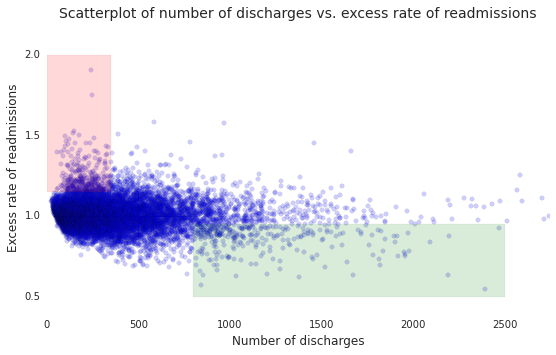

In [54]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary report

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****

## Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### Question A. Do you agree with the above analysis and recommendations? Why or why not?

####Answer:
No. The major problem seems to be that for a lower number of observations, the confidence interval will be larger (wider) than for larger numbers as a result of the CLT. For very small volumes, CLT even doesn't hold (even wider intervals).

A minor problem is that the footnotes seem to be ignored in the preliminary report. Many of the footnotes mention problems with data collection.

Another minor problem might be the remaining selection bias after cleaning. In the documentation, the selection bias seems to be excluded to some extent. The hospitals with complex treatments seem to be compensated for this through the scoring of the expected readmission rate. However, specialized hospitals (e.g., academic ones) might still suffer from admitting the most complex cases.

### B. Provide support for your arguments and your own recommendations with a statistically sound analysis:
Setup an appropriate hypothesis test.

Compute and report the observed significance value (or p-value).
Report statistical significance for α = .01.
Discuss statistical significance and practical significance

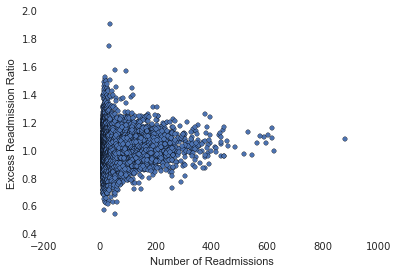

In [55]:
clean_hospital_read_df.plot(x="Number of Readmissions", y="Excess Readmission Ratio", kind='scatter')

(0, 7000)

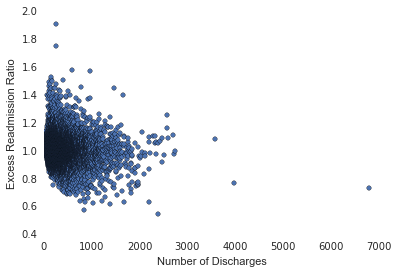

In [56]:
ax = clean_hospital_read_df.plot(x="Number of Discharges", y="Excess Readmission Ratio", kind='scatter')
ax.set_xlim(0,7000)


In [57]:
description['Excess Readmission Ratio']['mean']

1.0075037835957206

(0, 7000)

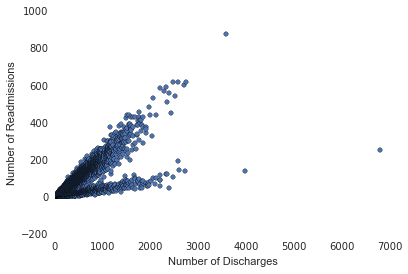

In [58]:
ax = clean_hospital_read_df.plot(x="Number of Discharges", y="Number of Readmissions", kind='scatter')
ax.set_xlim(0,7000)

In [59]:
def assignlabel(row):
    if row["Footnote"]>0:
        return "Q"
    if row["Excess Readmission Ratio"]>=1: 
        return "H" 
    else:
        return "L"

clean_hospital_read_df['HL']=clean_hospital_read_df.apply(assignlabel, axis=1)

In [60]:
clean_hospital_read_df.head(150)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,HL
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15625,FAIRVIEW DEVELOPMENTAL CENTER,50548,CA,READM-30-HF-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15642,WAGONER COMMUNITY HOSPITAL,370166,OK,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15648,ST LUKE'S HOSPITAL AT THE VINTAGE,670075,TX,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15652,SOUTH TEXAS SURGICAL HOSPITAL,670061,TX,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q
15396,GEORGE L MEE MEMORIAL HOSPITAL,50189,CA,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q


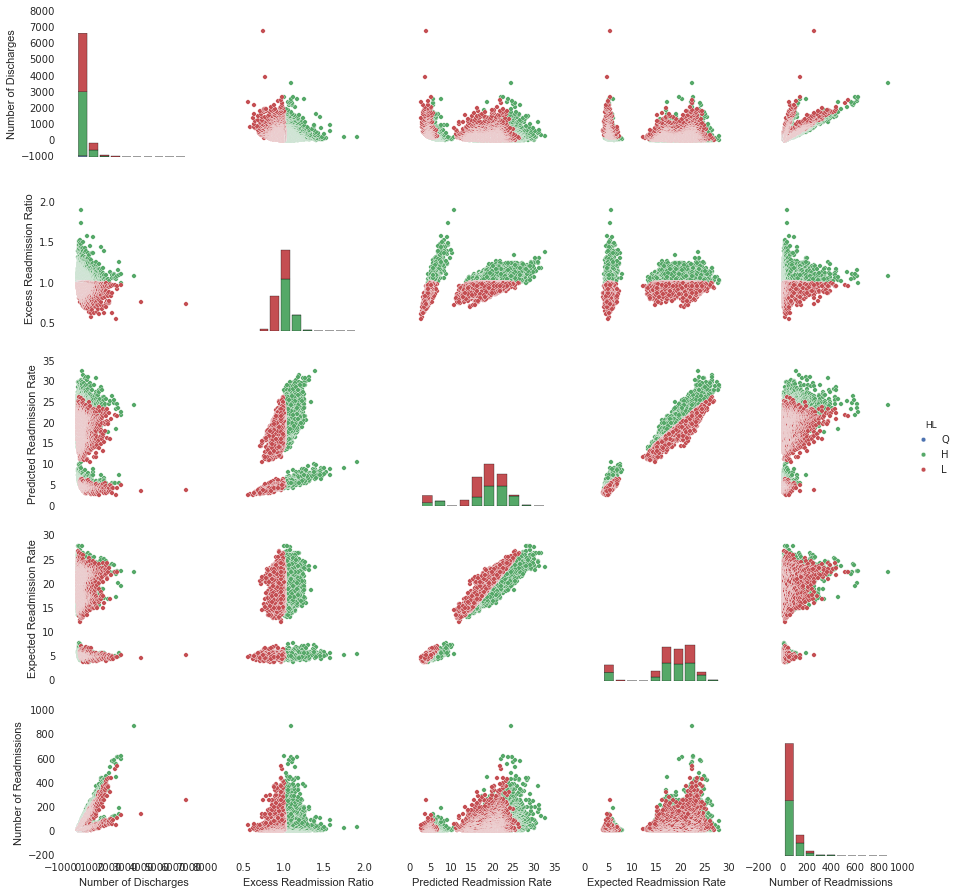

In [61]:
toplot=clean_hospital_read_df.drop(["Hospital Name", "Provider Number", "Footnote", "State", "Measure Name", "Start Date", "End Date"],1)
sns.pairplot(toplot, hue="HL")

Although the left-lower corner seems to show two groups, from the picutre excess admission ratio vs predicted readmission rate, it seems that the groups are well separated in H and L readmission rates. In other words, the selection bias seems to be eliminated properly.

Therefore, let's focus on the plot number of discharges (=n), with a confidence interval around the predicted readmission rate.

Only if the observed (called predicted here) readmission rate is significantly above the expected readmission rate, we can conclude that something significantly is going on in this hospital.


Let's add a confidence interval to the dataframe...

In [106]:
stats.binom.ppf(0.5, 400, 0.99)

396.0

In [118]:
from statsmodels.stats.proportion import proportion_confint

In [119]:
statsmodels.stats.proportion.proportion_confint(30,400,alpha=0.05)

(0.049188122613530456, 0.10081187738646954)

In [128]:
def addconf(row):
  
    n=row["Number of Discharges"]
    p=row["Expected Readmission Rate"]/100 # this assumes that the null Hypothesis holds true
    a = 0.01  

    if (n==0) or (p==0) or (p==1):
        return np.nan
    else:
        return sm.proportion.proportion_confint(n*p, n, alpha=a, method='normal')[1]*100
    
clean_hospital_read_df['CH']=clean_hospital_read_df.apply(addconf, axis=1)
clean_hospital_read_df

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,HL,CH
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15625,FAIRVIEW DEVELOPMENTAL CENTER,50548,CA,READM-30-HF-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15642,WAGONER COMMUNITY HOSPITAL,370166,OK,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15648,ST LUKE'S HOSPITAL AT THE VINTAGE,670075,TX,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15652,SOUTH TEXAS SURGICAL HOSPITAL,670061,TX,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN
15396,GEORGE L MEE MEMORIAL HOSPITAL,50189,CA,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN


In [148]:
def assignlabel2(row):
    if row["Footnote"]>0 or not(row["CH"]):
        return "Q"
    if row["CH"]<row["Predicted Readmission Rate"]: 
        return "NOK" 
    else:
        return "OK"

clean_hospital_read_df['HL2']=clean_hospital_read_df.apply(assignlabel2, axis=1)

In [149]:
clean_hospital_read_df.head(150)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,HL,CH,HL2
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15625,FAIRVIEW DEVELOPMENTAL CENTER,50548,CA,READM-30-HF-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15642,WAGONER COMMUNITY HOSPITAL,370166,OK,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15648,ST LUKE'S HOSPITAL AT THE VINTAGE,670075,TX,READM-30-HIP-KNEE-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15652,SOUTH TEXAS SURGICAL HOSPITAL,670061,TX,READM-30-COPD-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q
15396,GEORGE L MEE MEMORIAL HOSPITAL,50189,CA,READM-30-AMI-HRRP,0,7,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013,Q,NaN,Q


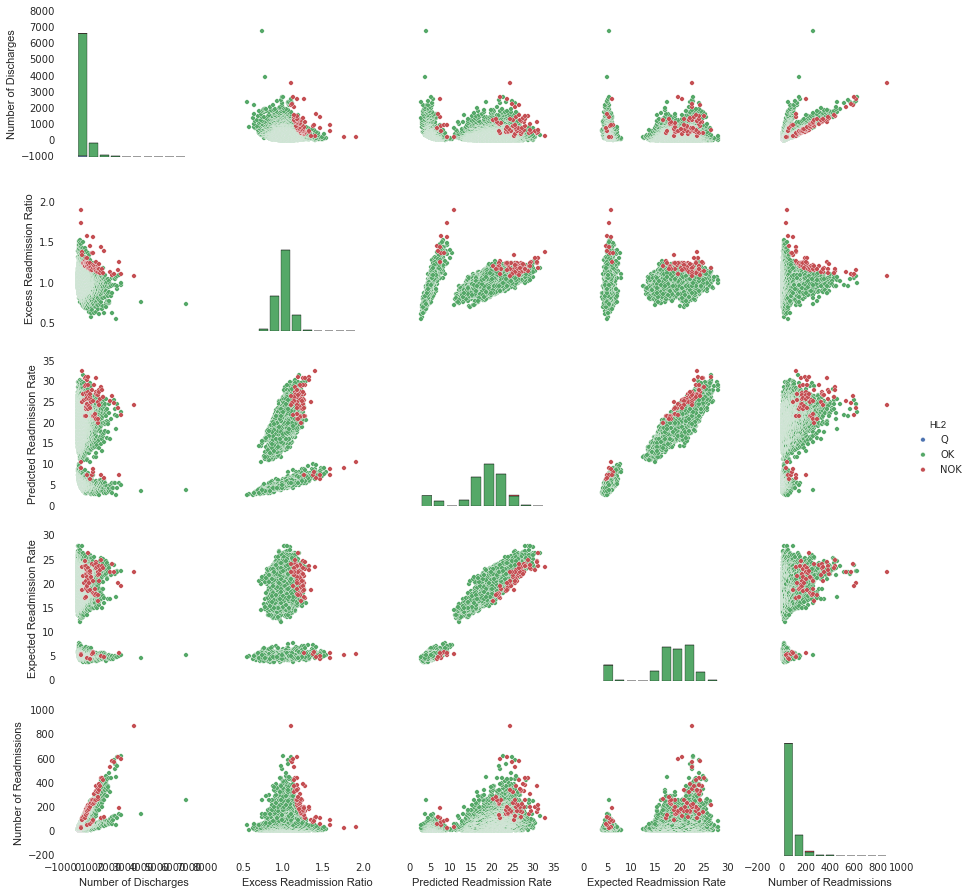

In [152]:
toplot=clean_hospital_read_df.drop(["Hospital Name", "Provider Number", "Footnote", "State", "Measure Name", "Start Date", "End Date", "HL", "CH"],1)
sns.pairplot(toplot, hue="HL2")

So this leaves only a fraction of the hospitals with statistically significant excess readmission rates.

In [176]:
toplot["HL2"].value_counts()

OK     11426
Q         81
NOK       71
dtype: int64

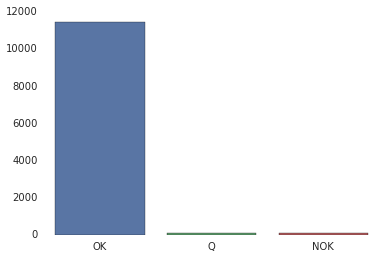

In [175]:
ax = sns.barplot(toplot["HL2"].value_counts().index, y=toplot["HL2"].value_counts())